In [8]:
import re
import pprint

import torch
import torch.nn as nn

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from seisLM.data_pipeline import foreshock_aftershock_dataloaders as loaders
from seisLM.model.task_specific import foreshock_aftershock_models as models
from seisLM.utils import project_path


In [9]:


def extract_num_classes(checkpoint_path):
    pattern = r'num_classes_(\d+)'
    match = re.search(pattern, checkpoint_path)
    if match:
        return int(match.group(1))
    return None


# Example usage
base_folder = '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/foreshock_aftershock_run'
checkpoints = project_path.list_all_checkpoints(
  base_folder, keywords=['2024-07-16', 'Conv1DShockClassifier', 'last'])


checkpoints_dict = {}

for checkpoint in checkpoints:
  num_classes = extract_num_classes(checkpoint)
  checkpoints_dict[str(num_classes)] = checkpoint

pp = pprint.PrettyPrinter(depth=4)
pp.pprint(checkpoints_dict)


{'2': '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/foreshock_aftershock_run/num_classes_2_seed_42_model_Conv1DShockClassifier_time_2024-07-16-12h-42m-40s/checkpoints/last.ckpt',
 '4': '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/foreshock_aftershock_run/num_classes_4_seed_42_model_Conv1DShockClassifier_time_2024-07-16-11h-52m-38s/checkpoints/last.ckpt',
 '8': '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/foreshock_aftershock_run/num_classes_8_seed_42_model_Conv1DShockClassifier_time_2024-07-16-12h-22m-41s/checkpoints/last.ckpt',
 '9': '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/foreshock_aftershock_run/num_classes_9_seed_42_model_Conv1DShockClassifier_time_2024-07-16-12h-08m-42s/checkpoints/last.ckpt'}


In [4]:
confusion_matrices = {}

for num_classes, checkpoint in checkpoints_dict.items():
  model = models.ShockClassifierLit.load_from_checkpoint(checkpoint)
  model.eval();

  dataloaders = loaders.prepare_foreshock_aftershock_dataloaders(
    num_classes=int(num_classes),
    component_order='ZNE',
    batch_size=32,
    event_split_method='temporal'
  )

  all_gt_class = []
  all_pred_class = []

  for X, y in dataloaders['test']:
    with torch.no_grad():
      logits = model(X.to(model.device)).cpu().numpy()
      pred_class = np.argmax(logits, axis=1)

    all_gt_class.append(y)
    all_pred_class.append(pred_class)

  all_gt_class = np.concatenate(all_gt_class)
  all_pred_class = np.concatenate(all_pred_class)


  cm = confusion_matrix(all_gt_class, all_pred_class)

  cm_percentage = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  confusion_matrices[num_classes] = cm_percentage

Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42


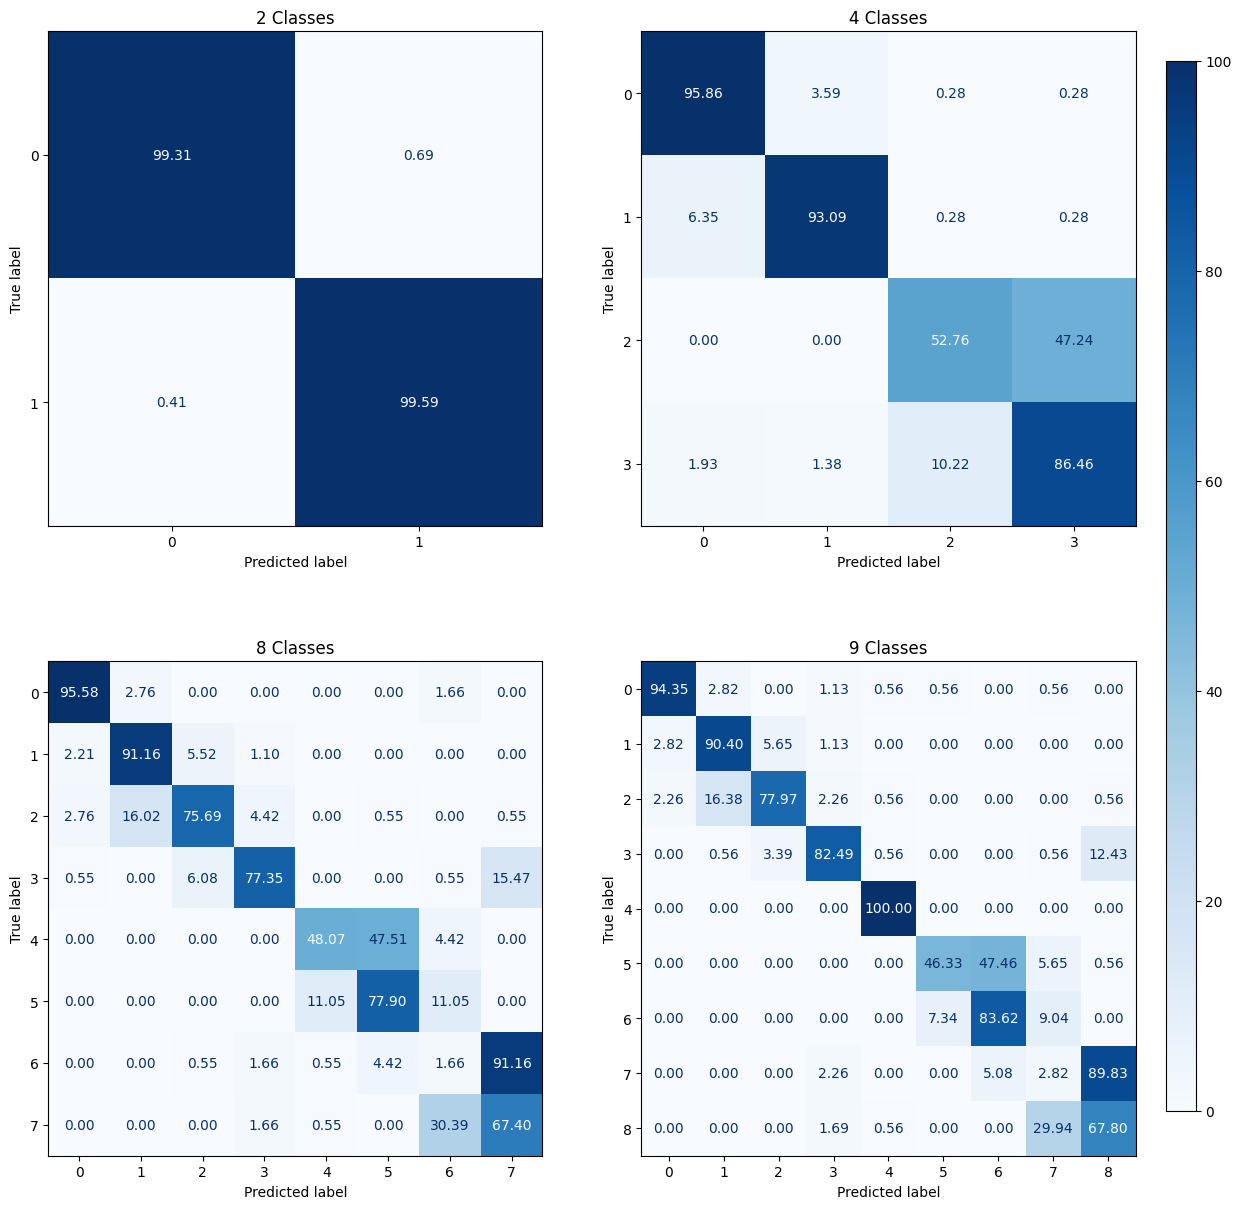

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])

# Define the titles and matrices
titles = ['2 Classes', '4 Classes', '8 Classes', '9 Classes']
matrices = [confusion_matrices['2'], confusion_matrices['4'], confusion_matrices['8'], confusion_matrices['9']]

for ax, matrix, title in zip(axes.flatten(), matrices, titles):
    # Normalize the confusion matrix by row
    cm_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    cm_percentage = cm_normalized * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
    im = disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.2f', colorbar=False)
    ax.set_title(title)

# Add shared colorbar
fig.colorbar(im.im_, cax=cbar_ax)
plt.show()